In [ ]:
"""Import necessary libraries."""

import numpy as np    # Uses built in DFT algorithms from Numpy
import matplotlib.pyplot as plt 
import pandas as pd

In [ ]:
"""Some useful functions, FFT/DFT replaced with Numpy implementation."""

def phase_angle(complex_value):
    """Finds am angle in the complex plane (ergo phase angle) for a given complex number."""
    angle = -np.angle(complex_value, deg = True)    # deg = False returns radians
    if angle < 0:
        angle += 360
    return angle

phi = 1    # Rotation angle in degrees

def rotate(complex_value, theta = (phi*np.pi/180)):
    """Rotate complex values counterclockwise in the imaginary plane by theta, preserving magnitude in output."""
    vector = np.array([[np.real(complex_value)], 
                       [np.imag(complex_value)]])    # Convert a + ib to vector [[a], [b]]
    operator = np.array([[np.cos(theta), -np.sin(theta)],    # Create rotation matrix
                         [np.sin(theta), np.cos(theta)]])
    new_vector = operator@vector    # Matrix multiplication for a rotated vector
    return new_vector[0][0].item()+new_vector[1][0].item()*1j

In [ ]:
"""Reads data from data point table *.dpt files extracted from OPUS Rapid Scan protocol using pandas."""

path = r"C:\Users\ryanh\OneDrive - UW-Madison\Hermans_Group\ME-DRIFTS\combinedMES\10Cu68Ga22Zr_June15"    # Set working directory, called again to save processed data
file = r"\10Cu68Ga22Zr_June15.0.dpt"    # The specifc path extension of the file
file_path = path + file    # Combine for full path 
print(file_path)    # To ensure correct path

dpt = pd.read_csv(file_path, sep = ",", header = None, delim_whitespace = False)    # Import data, *.dpt files from OPUS are in csv format
dim = dpt.shape

print("Number of wavenumbers sampled over wavenumber range: " + str(dim[0]))    # Check dimensions of imported data to ensure it matches expected number of scans, etc.
print("Number of scans: " + str(dim[1] - 1))

# The data frame is imported like so: wavenumbers in the first column, scans over that spectrum in successive columns.
# Data is organized by wavenumber, each row is a subsequent scan

header = []
for wavenumber in dpt.iloc[0: , 0]:    # Round to nearest wavenumber for convenience
    header.append(str(round(wavenumber)))

data = dpt.T[1:]
data.columns = header
#data

In [ ]:
"""Show a few key frequencies over the course of the experiment."""

# Make a figure with an oscillating wavenumber

start = 0 # initial scan number 
end = dim[1] - 1 # final scan number

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data["1988"]/np.max(data["1988"]), "g", label = "1988 $cm^{-1}$")    # Ga-H
ax.plot(data["2358"]/np.max(data["2358"]), "r", label = "2358 $cm^{-1}$")    # CO2
ax.plot(data["1581"]/np.max(data["1581"]), "b", label = "1581 $cm^{-1}$")    # Carbonates/formate?
#ax.plot(wavenumbers, dpt.iloc[:,dim[1]-1], "r", label="Last spectrum")
plt.xlabel("Scans over time")
plt.ylabel("Signal")
plt.title("Selected Wavenumber")
ax.set(
    xlim = (start, end),
    ylim = (0, 1)
    #xticks = np.arange(4000, 700, -500),
    )
ax.legend(loc="best")
plt.show()

In [ ]:
"""Average desired MES periods."""

n = 3 # Remove first n periods
N = 10 # Total number of periods
i = n

assert 0 < n < 10

spectrum = (n * 120)
avgd_period = data.iloc[spectrum: spectrum + 120, : ]

# Average remaining periods

while i < (N + 1):    # We use 10 periods, usually discard the first three
    avgd_period += data.iloc[spectrum: spectrum + 120, : ]
    i += 1
    
avgd_period /= (N - n)    # Normalize

"""Set mean intensity of each row (set of scans for each wavenumber) as 0.""" 

centered_period = avgd_period.sub(avgd_period.mean()).reset_index(drop = True)    # As in doc string
#centered_period = avgd_period.reset_index(drop = True)    # For testing, omits subtraction of mean
#centered_period    # Row index is scan number

"""Display averaged and centered period with normalized signals."""

fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))
scans = np.arange(1, 121)
ax.plot(centered_period["1988"]/np.max(centered_period["1988"]), "g", label = "1988 $cm^{-1}$")
ax.plot(centered_period["2358"]/np.max(centered_period["2358"]), "r", label = "2358 $cm^{-1}$")
ax.plot(centered_period["1581"]/np.max(centered_period["1581"]), "b", label = "1581 $cm^{-1}$")
ax.plot(np.real(np.exp(-1j*2*np.pi*scans/120)), "k", label = "rFFT")
ax.plot(np.imag(np.exp(-1j*2*np.pi*scans/120)), "m", label = "iFFT")
plt.xlabel("Scans over time")
plt.ylabel("Signal")
plt.title("Selected Wavenumbers")
ax.set(
    #xlim = (start, end),
    #ylim = (0, 2)
    #xticks = np.arange(4000, 700, -500),
    )
ax.legend(loc="best")
plt.show()

In [ ]:
"""Perform a discrete Fourier transform over the scans in each column/wavenumber."""

dft = centered_period.apply(np.fft.fft, axis = 0)
dft

In [ ]:
"""Look at frequencies"""

plt.figure(figsize = (12, 6))

plt.subplot(131)
plt.stem(np.arange(-len(dft["2358"])/2, len(dft["2358"])/2),
         np.abs(np.fft.fftshift(dft["2358"])), 
         linefmt='r',
         markerfmt=" ", 
         basefmt="-r")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(-6, 6)
plt.title("2358 $cm^{-1}$")

plt.subplot(132)
plt.stem(np.arange(-len(dft["1988"])/2, len(dft["1988"])/2),
         np.abs(np.fft.fftshift(dft["1988"])), 
         linefmt='g',
         markerfmt=" ", 
         basefmt="-g")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(-6, 6)
plt.title("1988 $cm^{-1}$")

plt.subplot(133)
plt.stem(np.arange(-len(dft["1581"])/2, len(dft["1581"])/2),
         10*np.abs(np.fft.fftshift(dft["1581"])), 
         linefmt='b',
         markerfmt=" ", 
         basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(-6, 6)
plt.title("1581 $cm^{-1}$")

plt.show()

# plt.subplot(132)
# plt.plot(freqx, np.abs(X), 'r')
# plt.plot(freqy, np.abs(Y), 'b')
# plt.xlabel('Freq (Hz)')
# plt.ylabel('FFT Amplitude |X(freq)|')
# plt.xlim(0, 20)

# plt.subplot(133)
# plt.plot(tx, np.fft.ifft(X), 'r')
# plt.plot(ty, np.fft.ifft(Y), 'b')
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.tight_layout()

An excerpt from:

Srinivasan, P. D.; Patil, B. S.; Zhu, H.; Bravo-Suárez, J. J. Application of Modulation Excitation-Phase Sensitive Detection-DRIFTS for in Situ 
/Operando Characterization of Heterogeneous Catalysts. React. Chem. Eng. 2019, 4 (5), 862–883. https://doi.org/10.1039/C9RE00011A.


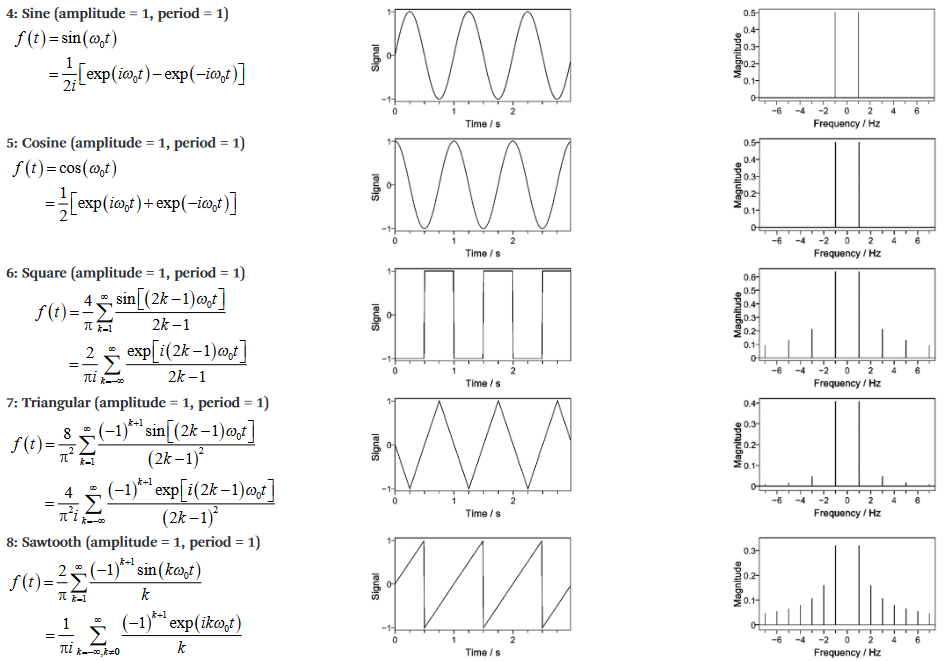

In [ ]:
"""Revert column titles to experimental wavenumbers."""

dft.columns = dpt.iloc[0: , 0]
dft

In [ ]:
"""Find peak phase angles for each wavenumber."""

angles = dft.applymap(phase_angle)    # Returns all phase angles in radians
angles

In [ ]:
"""Rotate complex values for each wavenumber."""

rotated = pd.DataFrame(dft.applymap(rotate))
rotated.applymap(phase_angle)    # Ensure rotation worked

In [ ]:
"""Create a dataframe of spectra for all specified phase angles."""

i = 1 # Index for iteration
phase_angle_array = pd.DataFrame(dft.iloc[1, : ]).T.to_numpy()    # Initiate numpy array

while i < 360:
    new_row = []
    for item in phase_angle_array[-1]:
        new_row.append(rotate(item))
    new = np.vstack((phase_angle_array, new_row))
    phase_angle_array = new
    i += 1
    
all_phase_angles = pd.DataFrame(data = phase_angle_array, columns = dft.columns)

In [ ]:
all_phase_angles

In [ ]:
"""Revert column titles to experimental wavenumbers."""

angles.columns = dpt.iloc[0: , 0]
angles

In [ ]:
"""Phase angle by wavenumber plot."""

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
plt.plot(angles.columns, angles.iloc[1, :])
ax.set(
    xlim = (4000, 800),
    ylim = (0, 360),
    xticks = np.arange(4000, 750, -100),
    yticks = np.arange(0, 370, 20)
)
plt.title("Phase Angles")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.ylabel("Angle")
plt.show()

In [ ]:
# fig.savefig(path + "\\phase_angles.jpg")

In [ ]:
"""Take the real components."""

real_components = all_phase_angles.applymap(np.real)
real_components #*= 10**16

In [ ]:
"""Revert column titles to experimental wavenumbers."""

real_components.columns = dpt.iloc[0: , 0]
real_components

In [ ]:
"""Plot real components."""

phase_angles = np.arange(0, 360, 30)    # Which angles to plot

fig, ax = plt.subplots(1, 1, figsize=(25, 5))
for angle in phase_angles:    # No more copying line by line to add angles
    ax.plot(real_components.columns, real_components.iloc[angle, :], label = str(angle))
ax.set(
    xlim = (4000, 800),
    ylim = (-0.015, 0.015),
    xticks = np.arange(4000, 750, -100),
    #yticks = np.arange(0, 370, 20)
)
plt.title("Phase Angles")
plt.xlabel("Wavenumber $cm^{-1}$")
plt.ylabel("Intensity")
plt.legend(loc = "upper left")
plt.show()

In [ ]:
# fig.savefig(path + "\\spectrum_by_phase_angles_simpson.jpg")

In [ ]:
# """Save all numerical results."""

# # Fourier transformed output and phase angles

# output_and_angles = pd.concat([complex_values, angles])
# save_to_excel_name = path + "\\FT_output_and_angles.xlsx"
# output_and_angles.to_excel(save_to_excel_name)

# #Save real components by phase angle data."""

# save_to_excel_name = path + "\\real_components_by_phase_angle.xlsx"
# real_components.to_excel(save_to_excel_name)